# Shoes images recognition - Sports or Formal?

## Import dependencies

In [184]:
# TensorFlow
import tensorflow as tf

# Keras
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import array_to_img, img_to_array, load_img

# Helper libraries
import random
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import io as skio
from skimage import filters
from skimage import morphology
import os
import re
import cv2
import sys

import colorsys
import utils
import argparse

from PIL import Image
import PIL

from IPython.display import Image

print(tf.__version__)

1.11.0


## Define variables and functions

In [2]:
class_names = ['Sporty', 'Classy']
target_size=(136,102)

In [3]:
# List all path of files under a directory

def list_pictures(path_directory):
    
    paths=[]
    
    for root, dirs, files in os.walk(path_directory):  
        for filename in files:
            paths.append(os.path.join(root, filename))
        
    return paths

In [4]:
def test_plot_image(i, predictions_array, true_label, img):
    
    prediction = predictions_array[i]
    
    true_label = np.argmax(true_label[i])
    
    img = img[i]
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:3.5f}% (Label: {})".format(class_names[predicted_label],
                                100.0*np.max(prediction),
                                class_names[true_label]),
                                color=color)

In [5]:
def predict_plot_image(img):

    color = "black"
    
    width,height=136,102
    image_resized = cv2.resize(img,(width, height))
    # cv2.imwrite('img-resize.jpg',image_resized)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    
    # Normalizing from 0 to 1
    image_resized = image_resized.astype('float32')
    image_resized = image_resized / 255.0
    
    # Reshape for to feed to CNN...
    img_ready = (np.expand_dims(image_resized,0))
    
    predictions_array = model.predict(img_ready)
    
    pred = np.argmax(predictions_array)

    predicted_label = np.argmax(predictions_array)
  
    plt.xlabel("{} {:3.5f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array)),
                                color=color)

In [6]:
def predict_plot_path(path):
    
    color = "black"
    
    img = cv2.imread(path)
    width,height=136,102
    image_resized = cv2.resize(img,(width, height))
    # cv2.imwrite('img-resize.jpg',image_resized)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    

    # Normalizing from 0 to 1
    image_resized = image_resized.astype('float32')
    image_resized = image_resized / 255.0
    
    # Reshape for to feed to CNN...
    img_ready = (np.expand_dims(image_resized,0))
    
    predictions_array = model.predict(img_ready)
    
    pred = np.argmax(predictions_array)

    predicted_label = np.argmax(predictions_array)
  
    plt.xlabel("{} {:3.5f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array)),
                                color=color)

In [151]:
def predict_path(path):
    
    color = "black"
    
    img = cv2.imread(path)
    width,height=136,102
    image_resized = cv2.resize(img,(width, height))
    cv2.imwrite('./temp/resized_img.jpg',image_resized)
    
    # Normalizing from 0 to 1
    image_resized = image_resized.astype('float32')
    image_resized = image_resized / 255.0
    
    # Reshape for to feed to CNN...
    img_ready = (np.expand_dims(image_resized,0))
    
    predictions_array = model.predict(img_ready)
    
    pred = np.argmax(predictions_array)

    predicted_label = np.argmax(predictions_array)
    
    return predicted_label

## Import dataset

In [9]:
X = []
Y = []

for picture in list_pictures('../shoes-recognition/shoesimages/Sports-clean/'):
    img = img_to_array(load_img(picture, target_size))
    X.append(img)
    Y.append(0)
    
    img_flip = np.flip(img, axis=1)
    X.append(img_flip)
    Y.append(0)
    
for picture in list_pictures('../shoes-recognition/shoesimages/Formals-clean/'):
    img = img_to_array(load_img(picture, target_size))
    X.append(img)
    Y.append(1)
    
    img_flip = np.flip(img, axis=1)
    X.append(img_flip)
    Y.append(1)

In [10]:
print('Pixel size of each image: {0}'.format(X[0].shape))

Pixel size of each image: (102, 136, 3)


In [11]:
print('Number of {0} shoes images: {1}'.format(class_names[0],Y.count(0)))
print('Number of {0} shoes images: {1}'.format(class_names[1],Y.count(1)))
print('Total images: {0}'.format(len(Y)))

Number of Sporty shoes images: 13212
Number of Classy shoes images: 8048
Total images: 21260


In [12]:
# Converting to Numpy array
X = np.asarray(X)
Y = np.asarray(Y)

# Normalizing from 0 to 1
X = X.astype('float32')
X = X / 255.0

# Converting to class
Y = np_utils.to_categorical(Y, 2)

# Training data & test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [13]:
print('Number of images for training: {0}'.format(len(X_train)))
print('Number of images for testing: {0}'.format(len(X_test)))
print('Total images: {0}'.format(len(X_train) + len(X_test)))

Number of images for training: 14244
Number of images for testing: 7016
Total images: 21260


## Build Convolutional Neural Network (CNN)

In [14]:
# CNN 3 CONV
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

## Training model (Excute either "Training model" or "Loading model")

<p>To train CNN, run this.

In [13]:
# Define callback for checkpoint
filepath="3CONVs-oversample-clean-session02-epoch{epoch:02d}-Valacc-{val_acc:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [14]:
##### TRAINING MODEL ##### 
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    batch_size=5, 
                    epochs=10, 
                    validation_data = (X_test, y_test), 
                    callbacks=[checkpointer])

Train on 14244 samples, validate on 7016 samples
Epoch 1/10
14244/14244 [==============================] - 259s 18ms/step - loss: 0.3361 - acc: 0.8586 - val_loss: 0.2088 - val_acc: 0.9209

Epoch 00001: val_acc improved from -inf to 0.92090, saving model to 3CONVs-oversample-clean-session02-epoch01-Valacc-0.9209.hdf5
Epoch 2/10
14244/14244 [==============================] - 253s 18ms/step - loss: 0.1938 - acc: 0.9231 - val_loss: 0.1578 - val_acc: 0.9414

Epoch 00002: val_acc improved from 0.92090 to 0.94142, saving model to 3CONVs-oversample-clean-session02-epoch02-Valacc-0.9414.hdf5
Epoch 3/10
14244/14244 [==============================] - 253s 18ms/step - loss: 0.1417 - acc: 0.9452 - val_loss: 0.1268 - val_acc: 0.9494

Epoch 00003: val_acc improved from 0.94142 to 0.94940, saving model to 3CONVs-oversample-clean-session02-epoch03-Valacc-0.9494.hdf5
Epoch 4/10
14244/14244 [==============================] - 253s 18ms/step - loss: 0.1134 - acc: 0.9562 - val_loss: 0.1133 - val_acc: 0.9558

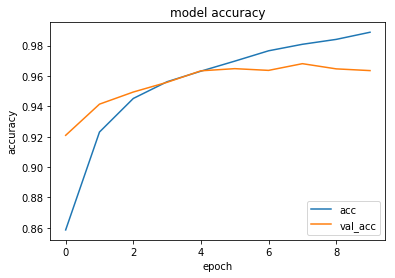

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

## Loading trained model  (Excute either "Training model" or "Loading model")

<p> To load trained model, run this.

In [15]:
##### LOADING MODEL #####

# load the network weights
filename = "../shoes-recognition/3CONVs-oversample-clean-session02-epoch08-Valacc-0.9681.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

## Confusion matrix of the model

In [16]:
# Predict class of test data
predict_classes = model.predict_classes(X_test)

# Marging...
mg_df = pd.DataFrame({'predict': predict_classes, 'label': np.argmax(y_test, axis=1)})

# Create confusion matrix
pd.crosstab(mg_df['label'], mg_df['predict'])

predict     0     1
label              
0        4304    53
1          45  2614

## Testing CNN

In [17]:
# Get output on final layer
predict_array = model.predict(X_test)

### Listing False Sporty

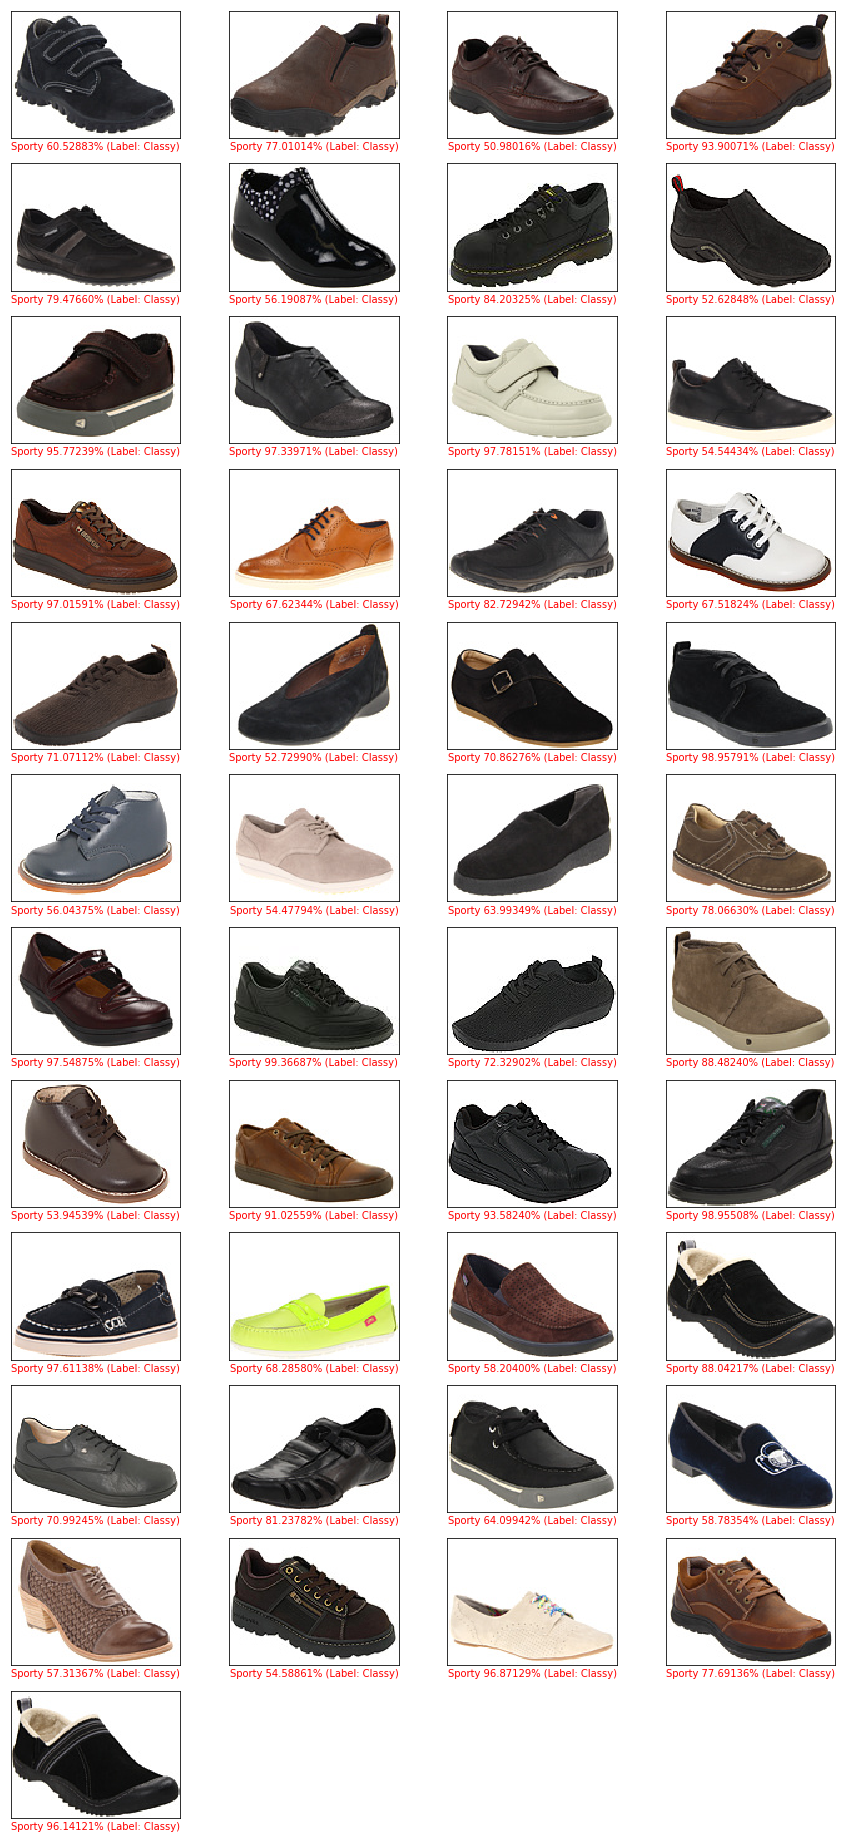

In [19]:
fig = plt.figure(figsize=(15,140))
for i, j in enumerate(mg_df[(mg_df["predict"]!=mg_df["label"]) & (mg_df["predict"]==0)].index):
    plt.subplot(50,4,1+i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    test_plot_image(j, predict_array, y_test, X_test)
    
fig.savefig("./errors-oversampling-clean-false-sports.jpg")

### False Classy

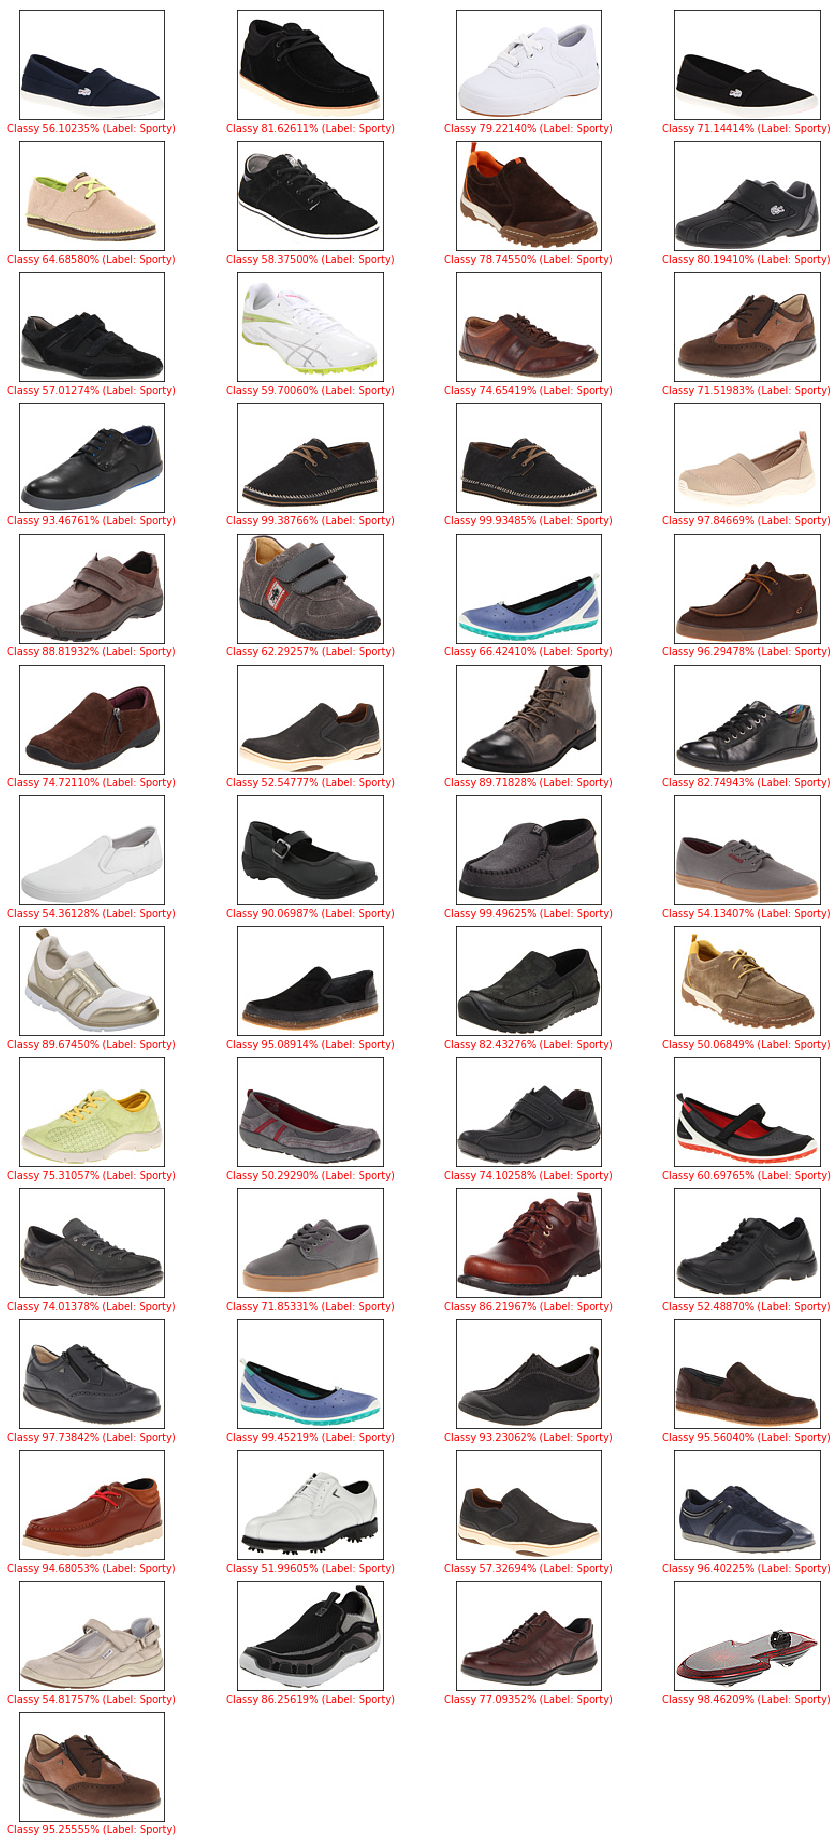

In [21]:
fig = plt.figure(figsize=(15,120))
for i, j in enumerate(mg_df[(mg_df["predict"]!=mg_df["label"]) & (mg_df["predict"]==1)].index):
    plt.subplot(50,4,1+i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    test_plot_image(j, predict_array, y_test, X_test)
    
fig.savefig("./errors-oversampling-clean-false-formal.jpg")

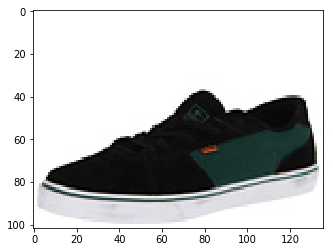

In [22]:
plt.imshow(X_test[0])

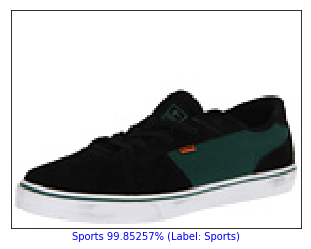

In [21]:
test_plot_image(0, predict_array, y_test, X_test)

Text(0.5,0,'Formal 100%')

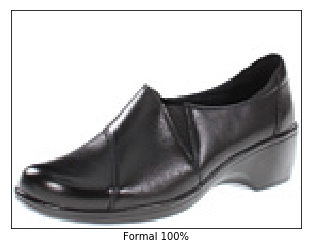

In [53]:
img = cv2.imread('./shoesimages/Formals/7995755.3.jpg')
width,height=136,102
image_resized = cv2.resize(img,target_size)

plt.grid(False)
plt.xticks([])
plt.yticks([])

plt.imshow(img, cmap=plt.cm.binary)

# Reshape for one image input...
img_ready = (np.expand_dims(image_resized,0))

predictions_array = model.predict(img_ready)

# print(predictions_array)

pred = np.argmax(predictions_array)

predicted_label = np.argmax(predictions_array)

# print(predicted_label)

plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                            100*np.max(predictions_array)),
                            color="black")

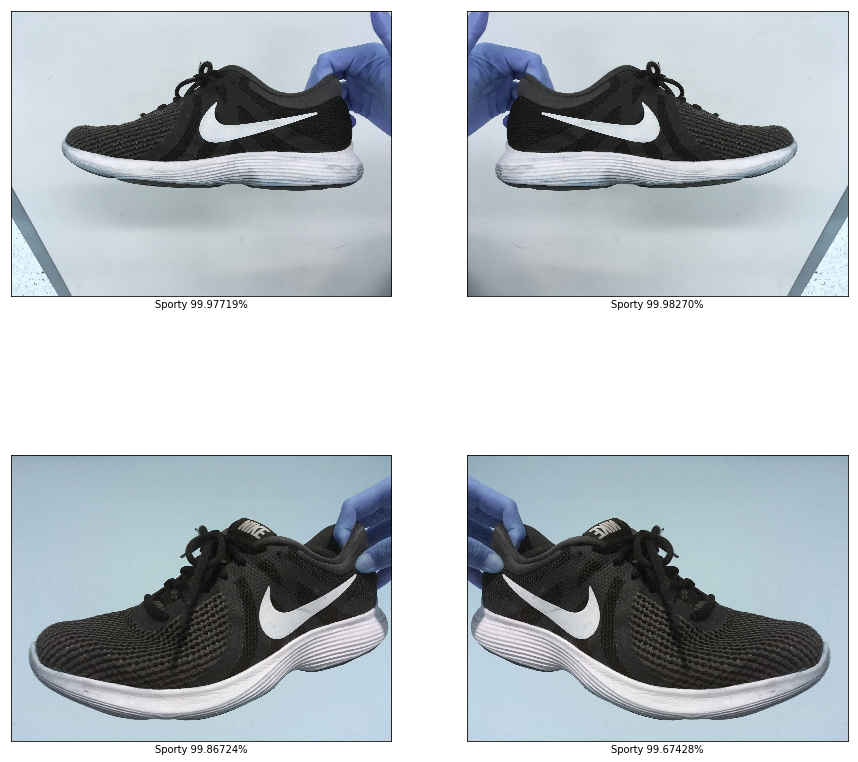

In [25]:
fig = plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
predict_plot_path("../shoes-recognition/shoesimages/demos/daichi-side-flip.jpg")
plt.subplot(2,2,2)
predict_plot_path("../shoes-recognition/shoesimages/demos/daichi-side.jpg")
plt.subplot(2,2,3)
predict_plot_path("../shoes-recognition/shoesimages/demos/daichi-angle.jpg")
plt.subplot(2,2,4)
predict_plot_path("../shoes-recognition/shoesimages/demos/daichi-angle-flip.jpg")
plt.show()
fig.savefig("./NIKE_demo.jpg")

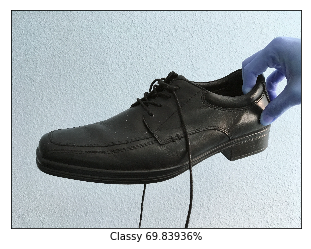

In [30]:
predict_plot_path("../shoes-recognition/shoesimages/demos/Rodri01.jpg")

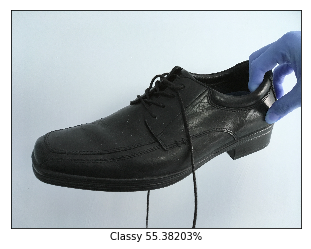

In [27]:
predict_plot_path("../shoes-recognition/shoesimages/demos/Rodri02.jpg")

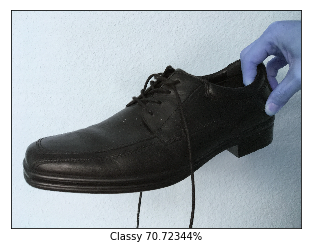

In [28]:
predict_plot_path("../shoes-recognition/shoesimages/demos/Rodri03.jpg")

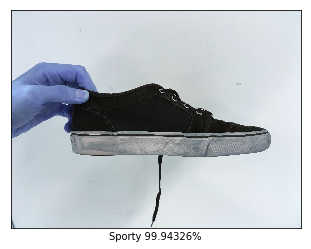

In [29]:
predict_plot_path("../shoes-recognition/shoesimages/demos/jason.jpg")

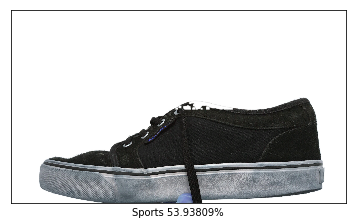

In [30]:
predict_plot_path("./shoesimages/demos-removeback/real_shoe_new.jpg")

### Structure of CNN

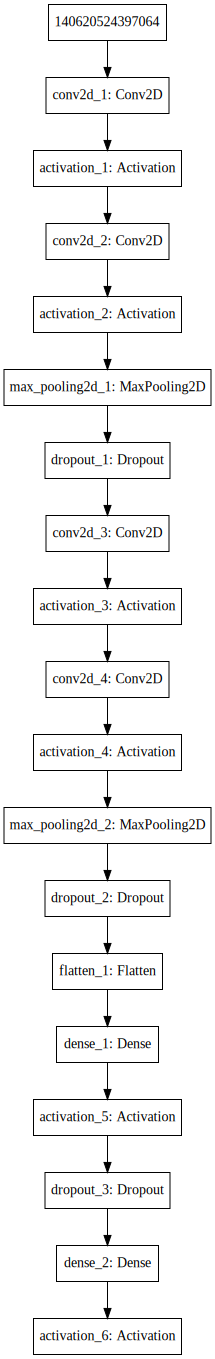

In [31]:

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## ColorDetection

In [33]:
# hist = histogram, centroids = cluster centers
# returns list of primary colors sorted by number of clusters each color has
def rank_colors(hist, centroids):
    '''
    white = [255,255,255]
    yellow = [255,255,0]
    orange = [255,165,0]
    red = [255,0,0]
    brown = [165,42,42]
    gray = [128,128,128]
    purple = [128,0,128]
    green = [0,255,0]
    blue = [0,0,255]
    black = [0,0,0]
    '''
    
    colors_count = {}
    
    for (percent, color) in zip(hist, centroids):
        print(color)
        r,g,b = color
        # fill colors_count -> get the number of clusters for each color
        if (r<=192):
            if(r<=64 and g<=128 and b<=128):
                key = 'black'
            if(r<=64 and g<=128 and b>128):
                key = 'blue'
            if(r<=64 and g>128):
                key = 'green'
            if(r>64 and g<=85 and b<=85):
                key = 'brown'
            if(r>64 and g<=85 and b>85):
                key = 'purple'
            if(r>64 and g>85):
                key = 'gray'
        else:
            if(g<=82):
                key = 'red'
            else:
                if(b>128):
                    key = 'white'
                else:
                    if(g<=210):
                        key = 'orange'
                    else:
                        key = 'yellow'
        colors_count.setdefault(key, 0)
        colors_count[key]+=1
                            
    # sort colors_count by value
    ranks = sorted(colors_count.items(), key=lambda x: x[1])
    return ranks[::-1]

In [34]:
#made with help from https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image
# replaces background with given color in bgr and saves to new path
    # default color = yellow bc yellow is not used as a shoe color
    #img_path = src, new_img_path = dest
def replace_background(img_path, new_img_path, color=(0.0,1.0,1.0)):
    #== Parameters =======================================================================
    BLUR = 21
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 200
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = color # yellow In BGR format
    #== Processing =======================================================================

    #-- Read image -----------------------------------------------------------------------
    img = cv2.imread(str(img_path))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Previously, for a previous version of cv2, this line was: 
    #  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Thanks to notes from commenters, I've updated the code but left this note
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))
    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 

    #cv2.imshow('img', masked)                                   # Display
    #cv2.waitKey(5)
    cv2.imwrite(new_img_path, masked)

In [35]:
# formal will only allow colors black, light brown, dark brown

def rank_colors_pixels_HSV2_formal(image):
    '''
    white = [255,255,255]
    yellow = [255,255,0]
    orange = [255,165,0]
    red = [255,0,0]
    brown = [165,42,42]
    gray = [128,128,128]
    purple = [128,0,128]
    green = [0,255,0]
    blue = [0,0,255]
    black = [0,0,0]
    '''
    
    colors_count = {}
    
    for r,g,b in image:
        key = ''
        hue,saturation,brightness = colorsys.rgb_to_hsv(r,g,b)
        brightness = brightness/255
        hue = hue*360
        #print(hue,saturation,brightness)
        
        if (brightness>0 and brightness<=0.2):
            key='black'
        #elif (saturation > 0 and saturation<=0.5) and (brightness>0.8 and brightness<=1.0):
        #    key='white'
        elif (hue>15 and hue<=45) and (saturation > 0.2 and saturation<=0.8) and (brightness>0.3 and brightness<=0.8):
            if (brightness>0.3 and brightness <= 0.5):
                key='dbrown'
            else:
                key='lbrown'
        elif (hue>30 and hue<=45) and (saturation > 0.3 and saturation<=0.8) and (brightness>0.3 and brightness<=0.8):
            if (brightness>0.3 and brightness <= 0.5):
                key='dbrown'
            else:
                key='lbrown'
        elif (hue>330 and hue<=360) and (saturation > 0.3 and saturation<=1.0) and (brightness>0.3 and brightness<=0.4):
            key='dbrown'
        elif (hue>=0 and hue<=15) or (hue>345 and hue<=360):
            key='red'
            if (brightness>0.3 and brightness <= 0.5):
                key='dbrown'
            elif (brightness>0.5 and brightness <= 1.0):
                key='lbrown'
            #elif (brightness>0.8):
            #    key='white'
            elif (brightness<0.3):
                key='black'
        
        '''
        if (saturation > 0.075 and saturation<=0.1) and (brightness>0.3 and brightness<=0.6):
            key='gray'
        elif (saturation > 0.05 and saturation<=0.075) and (brightness>0.3 and brightness<=0.75):
            key='gray'
        elif (saturation > 0 and saturation<=0.05) and (brightness>0.3 and brightness<=0.8):
            key='gray'
        
        elif (hue>295 and hue<=345):
            key='pink'
        elif (hue>265 and hue<=295):
            key='purple'
        elif (hue>165 and hue<=265):
            key='blue'
        elif (hue>65 and hue<=165):
            key='green'
        
        elif (hue>45 and hue<=65):
            key='yellow'
        
        elif (hue>15 and hue<=45):
            key='orange'
        '''
    
    
        colors_count.setdefault(key, 0)
        colors_count[key]+=1
    
                            
    # sort colors_count by value
    ranks = sorted(colors_count.items(), key=lambda x: x[1])
    return ranks[::-1]

In [91]:
def rank_colors_pixels_HSV2_sport(image):
    colors_count = {}
    
    for r,g,b in image:
        key = ''
        hue,saturation,brightness = colorsys.rgb_to_hsv(r,g,b)
        brightness = brightness/255
        hue = hue*360
        #print(hue,saturation,brightness)
        
        if (saturation > 0.075 and saturation<=0.1) and (brightness>0.3 and brightness<=0.6):
            key='gray'
        elif (saturation > 0.05 and saturation<=0.075) and (brightness>0.3 and brightness<=0.75):
            key='gray'
        elif (saturation >= 0 and saturation<=0.05) and (brightness>0.3 and brightness<=0.8):
            key='gray'
        elif (brightness>=0 and brightness<=0.2):
            key='black'
        elif (saturation >= 0 and saturation<=0.25) and (brightness>0.8 and brightness<=1.0):
            key='white'
        elif (hue>15 and hue<=45) and (saturation > 0.2 and saturation<=0.8) and (brightness>0.3 and brightness<=0.8):
            if (brightness>0.3 and brightness <= 0.5):
                key='dbrown'
            else:
                key='lbrown'
        elif (hue>30 and hue<=45) and (saturation > 0.3 and saturation<=0.8) and (brightness>0.3 and brightness<=0.8):
            if (brightness>0.3 and brightness <= 0.5):
                key='dbrown'
            else:
                key='lbrown'
        elif (hue>330 and hue<=360) and (saturation > 0.3 and saturation<=1.0) and (brightness>0.3 and brightness<=0.4):
            key='dbrown'

        elif (hue>=0 and hue<=15) or (hue>345 and hue<=360):
            key='red'
        elif (hue>295 and hue<=345):
            key='pink'
        elif (hue>265 and hue<=295):
            key='purple'
        elif (hue>165 and hue<=265):
            key='blue'
        elif (hue>65 and hue<=165):
            key='green'
        
        elif (hue>45 and hue<=65):
            key='yellow'
        '''
        elif (hue>15 and hue<=45):
            key='orange'
        '''
    
    
        colors_count.setdefault(key, 0)
        colors_count[key]+=1
    
                            
    # sort colors_count by value
    ranks = sorted(colors_count.items(), key=lambda x: x[1])
    return ranks[::-1]

In [97]:
# returns list of primary colors sorted by number of pixels each color has
def rank_colors_pixels_HSV2(image, shoe_type='Classy'):
    '''
    white = [255,255,255]
    yellow = [255,255,0]
    orange = [255,165,0]
    red = [255,0,0]
    brown = [165,42,42]
    gray = [128,128,128]
    purple = [128,0,128]
    green = [0,255,0]
    blue = [0,0,255]
    black = [0,0,0]
    '''
    
    if (shoe_type == 'Classy'):
        return rank_colors_pixels_HSV2_formal(image)
    if (shoe_type == 'Sporty'):
        return rank_colors_pixels_HSV2_sport(image)

In [98]:
#takes sorted list of colors, returns most prominent that is not yellow or invalid
def get_best(ranks):
    index = 0
    while (ranks[index][0]=='yellow' or ranks[index][0]==''): # color key at that index
        index+=1
    return ranks[index]

In [99]:
def color_recognition(img_path, new_img_path, shoe_type='Classy'):
    '''
    # construct the argument parser and parse the arguments
    ap = argparse.ArgumentParser()
    ap.add_argument("-i", "--image", required = True, help = "Path to the image")
    ap.add_argument("-c", "--clusters", required = True, type = int,
        help = "# of clusters")
    #args = vars(ap.parse_args())
    '''
    
    # load the image and convert it from BGR to RGB so that
    # we can dispaly it with matplotlib
    #image = cv2.imread(args["image"])
    replace_background(img_path, new_img_path)
    #image = cv2.imread(str(img_path))
    image = cv2.imread(str(new_img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # show our image
    plt.figure()
    plt.axis("off")
    plt.imshow(image)

    # reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    '''
    # cluster the pixel intensities

    #clt = KMeans(n_clusters = args["clusters"])
    clt = KMeans(n_clusters=10)
    clt.fit(image)

    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    hist = utils.centroid_histogram(clt)
    bar = utils.plot_colors(hist, clt.cluster_centers_)
    '''
    
    #ranks = rank_colors(hist, clt.cluster_centers_)
    ranks = rank_colors_pixels_HSV2(image, shoe_type)
    best = get_best(ranks)[0] # 0 index is color.
    return best
    '''
    # show our color bart
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    '''

In [168]:
def color_recognition_noplot(img_path, new_img_path, shoe_type='Classy'):
    '''
    # construct the argument parser and parse the arguments
    ap = argparse.ArgumentParser()
    ap.add_argument("-i", "--image", required = True, help = "Path to the image")
    ap.add_argument("-c", "--clusters", required = True, type = int,
        help = "# of clusters")
    #args = vars(ap.parse_args())
    '''
    
    # load the image and convert it from BGR to RGB so that
    # we can dispaly it with matplotlib
    #image = cv2.imread(args["image"])
    replace_background(img_path, new_img_path)
    #image = cv2.imread(str(img_path))
    image = cv2.imread(str(new_img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    '''
    # cluster the pixel intensities

    #clt = KMeans(n_clusters = args["clusters"])
    clt = KMeans(n_clusters=10)
    clt.fit(image)

    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    hist = utils.centroid_histogram(clt)
    bar = utils.plot_colors(hist, clt.cluster_centers_)
    '''
    
    #ranks = rank_colors(hist, clt.cluster_centers_)
    ranks = rank_colors_pixels_HSV2(image, shoe_type)
    best = get_best(ranks)[0] # 0 index is color.
    return best
    '''
    # show our color bart
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    '''

'black'

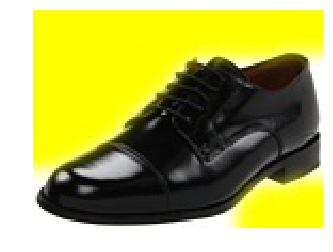

In [133]:
img_path = "../shoes-recognition/shoesimages/Formals/100627.72.jpg"
new_img_path = "./temp/new_img.jpg"
color_recognition(img_path, new_img_path,'Classy')

## Replace background

In [56]:
#made with help from https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image
# replaces background with given color in bgr and saves to new path
    # default color = yellow bc yellow is not used as a shoe color
    #img_path = src, new_img_path = dest
def replace_background(img_path, new_img_path, color=(0.0,1.0,1.0)):
    #== Parameters =======================================================================
    BLUR = 21
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 200
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = color # yellow In BGR format
    #== Processing =======================================================================

    #-- Read image -----------------------------------------------------------------------
    img = cv2.imread(str(img_path))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Previously, for a previous version of cv2, this line was: 
    #  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Thanks to notes from commenters, I've updated the code but left this note
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))
    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 

    #cv2.imshow('img', masked)                                   # Display
    #cv2.waitKey(5)
    cv2.imwrite(new_img_path, masked)

## ColorMap

In [172]:
formals_shoes_pants = {
    "black" : ["black", "lgrey", "dgrey"],
    "dbrown" : ["tan", "olive", "white"],
    "lbrown" : ["blue", "olive", "brown", "tan", "white", "beige", "red"]
}

sports_shoes_pants = {
    "black" : ["blue", "brown", "white", "black"],
    "red"   : ["blue", "tan", "white", "beige"],
    "blue"  : ["blue", "lgrey", "dgrey", "brown", "tan", "olive", "white", "beige", "red", "black", "lgrey", "dgrey"],
    "green" : ["blue", "tan", "white", "beige"],
    "gray"  : ["black", "blue", "brown", "white", "red"],
    "pink"  : ["blue", "dgrey"],
    "lbrown" : ["blue", "olive", "brown", "tan", "white", "beige", "red"],
    "dbrown" : ["tan", "olive", "white"],
    "white"  : ["black"]
}

sports_pants_shirt = {
    "blue" : ["white", "pink", "olive", "red"],
    "brown" : ["white", "dblue", "black", "pink"],
    "white" : ["dblue"],
    "tan" : ["white", "dblue", "black", "pink"],
    "beige" : ["white", "dblue", "black", "pink"],
    "lgrey" : ["white", "lblue", "pink"],
    "dgrey" : ["black", "pink", "dblue", "lblue"],
    "olive" : ["white", "dblue", "pink"],
    "red" : ["dblue", "white"],
    "black" : ["white", "pink", "lblue", "red"]
}

sports_shirt_hat = {
    "white" : ["grey", "black"],
    "pink" : ["white"],
    "olive" : ["grey", "black"],
    "dblue" : ["grey", "white"],
    "lblue" : ["black"],
    "black" : ["grey"],
    "red"   : ["grey", "blue"]
}

formals_pants_shirts = {
    "beige" : ["lblue", "white"],
    "black" : ["lblue", "white", "grey"],
    "blue"  : ["white", "pink", "grey"],
    "brown" : ["white", "pink"],
    "lgrey" : ["lblue", "white"],
    "dgrey" : ["dblue", "white"],
    "olive" : ["lblue", "white"],
    "red"   : ["white"],
    "tan"   : ["lblue", "white", "black"],
    "white" : ["lblue", "dblue"]
}

def createFormalMoodBoard(pantColor, shirtColor, shoeColor):
    images = ['UTStore/Formal_Shirts/' + shirtColor + 
    '.jpg','UTStore/Formal_Pants/' + pantColor + 
    '.jpg', 'UTStore/Belts/' + shoeColor + '.jpg', shoeColor + '.jpg']
    plt.figure(figsize=(10,10)) 
    for i in range(4):
        plt.subplot(4,1,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = mpimg.imread(images[i])
        plt.imshow(img, cmap=plt.cm.binary)
        
def createSportsMoodBoard(pantColor, shirtColor, shoeColor, hatColor):
    images = ['UTStore/Hats/' + hatColor + 
    '.jpg','UTStore/Sports_Shirts/' + shirtColor + 
    '.jpg', 'UTStore/Sports_Pants/' + pantColor + '.jpg', shoeColor + '1.jpg']
    plt.figure(figsize=(10,10)) 
    for i in range(4):
        plt.subplot(4,1,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = mpimg.imread(images[i])
        plt.imshow(img, cmap=plt.cm.binary) 

def getFormalShirtsColors(pantColor):
    return formals_pants_shirts[pantColor]

def getFormalsPantsColor(shoeColor):
    return formals_shoes_pants[shoeColor]

def getSportsPantsColor(shoeColor):
    return sports_shoes_pants[shoeColor]

def getSportsShirtsColors(pantColor):
    return sports_pants_shirt[pantColor]

def getHatColor(shirtColor):
    return sports_shirt_hat[shirtColor]


def colorMap(shoeColor, type):
    pantColors = []
    shirtColors = []
    if type == 1:
        pantColors = getFormalsPantsColor(shoeColor)
        chosenPantColor = random.choice(pantColors)
        shirtColors = getFormalShirtsColors(chosenPantColor)
        chosenShirtColor = random.choice(shirtColors)
        createFormalMoodBoard(chosenPantColor, chosenShirtColor, shoeColor)
    else:
        pantColors = getSportsPantsColor(shoeColor)
        chosenPantColor = random.choice(pantColors)
        shirtColors = getSportsShirtsColors(chosenPantColor)
        chosenShirtColor = random.choice(shirtColors)
        hatColors = getHatColor(chosenShirtColor)
        chosenHatColor = random.choice(hatColors)
        createSportsMoodBoard(chosenPantColor, chosenShirtColor, shoeColor, chosenHatColor)

In [214]:
def createFormalMoodBoardWithInput(pantColor, shirtColor, shoeColor, img_path):
    images = ['UTStore/Formal_Shirts/' + shirtColor + 
    '.jpg','UTStore/Formal_Pants/' + pantColor + 
    '.jpg', 'UTStore/Belts/' + shoeColor + '.jpg', shoeColor + '.jpg']
    plt.figure(figsize=(10,10)) 
    for i in range(3):
        plt.subplot(4,1,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = mpimg.imread(images[i])
        plt.imshow(img, cmap=plt.cm.binary)
        
    plt.subplot(4,1,4)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)       
    img = mpimg.imread(img_path)
    plt.imshow(img, cmap=plt.cm.binary)
        
def createSportsMoodBoardWithInput(pantColor, shirtColor, shoeColor, hatColor, img_path):
    images = ['UTStore/Hats/' + hatColor + 
    '.jpg','UTStore/Sports_Shirts/' + shirtColor + 
    '.jpg', 'UTStore/Sports_Pants/' + pantColor + '.jpg', shoeColor + '1.jpg']
    plt.figure(figsize=(10,10)) 
    for i in range(3):
        plt.subplot(4,1,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = mpimg.imread(images[i])
        plt.imshow(img, cmap=plt.cm.binary)
    
    plt.subplot(4,1,4)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(img_path)
    plt.imshow(img, cmap=plt.cm.binary)

def colorMapWithInput(shoeColor, type, img_path):
    pantColors = []
    shirtColors = []
    if type == 1:
        pantColors = getFormalsPantsColor(shoeColor)
        chosenPantColor = random.choice(pantColors)
        shirtColors = getFormalShirtsColors(chosenPantColor)
        chosenShirtColor = random.choice(shirtColors)
        createFormalMoodBoardWithInput(chosenPantColor, chosenShirtColor, shoeColor, img_path)
    else:
        pantColors = getSportsPantsColor(shoeColor)
        chosenPantColor = random.choice(pantColors)
        shirtColors = getSportsShirtsColors(chosenPantColor)
        chosenShirtColor = random.choice(shirtColors)
        hatColors = getHatColor(chosenShirtColor)
        chosenHatColor = random.choice(hatColors)
        createSportsMoodBoardWithInput(chosenPantColor, chosenShirtColor, shoeColor, chosenHatColor, img_path)

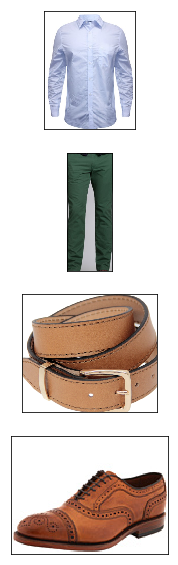

In [204]:
colorMap("lbrown", 1)

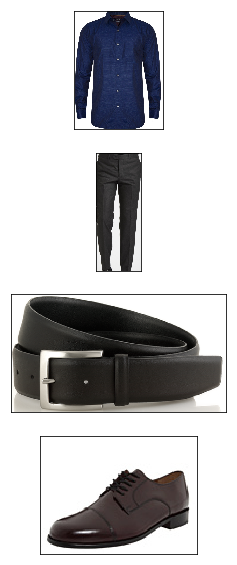

In [205]:
colorMapWithInput("black", 1, "./Formals/100627.255.jpg")

## Fashon Board

In [215]:
def fashionBoard(img_path):
    img_background_path = "./temp/img_background.jpg"
    replace_background(img_path, img_background_path, color=(1.0,1.0,1.0))
    
    img_background= cv2.imread(img_background_path)
    
    img_background_path = "./temp/resized_img.jpg"
    temp_recog_path = "./temp/recognition.jpg"
    
    color_recognition_noplot(img_background_path, temp_recog_path, class_names[predict_path(img_background_path)])
    
    category = predict_path(img_background_path)
    
    colorMapWithInput(color_recognition_noplot(img_background_path, temp_recog_path, class_names[category]), 
                      category, 
                      img_path)

## Demo 01 (Walkthrough)

In [196]:
img_path = "../shoes-recognition/shoesimages/demos/jason01.jpg"
img_background_path = "./temp/img_background.jpg"
replace_background(img_path, img_background_path, color=(1.0,1.0,1.0))

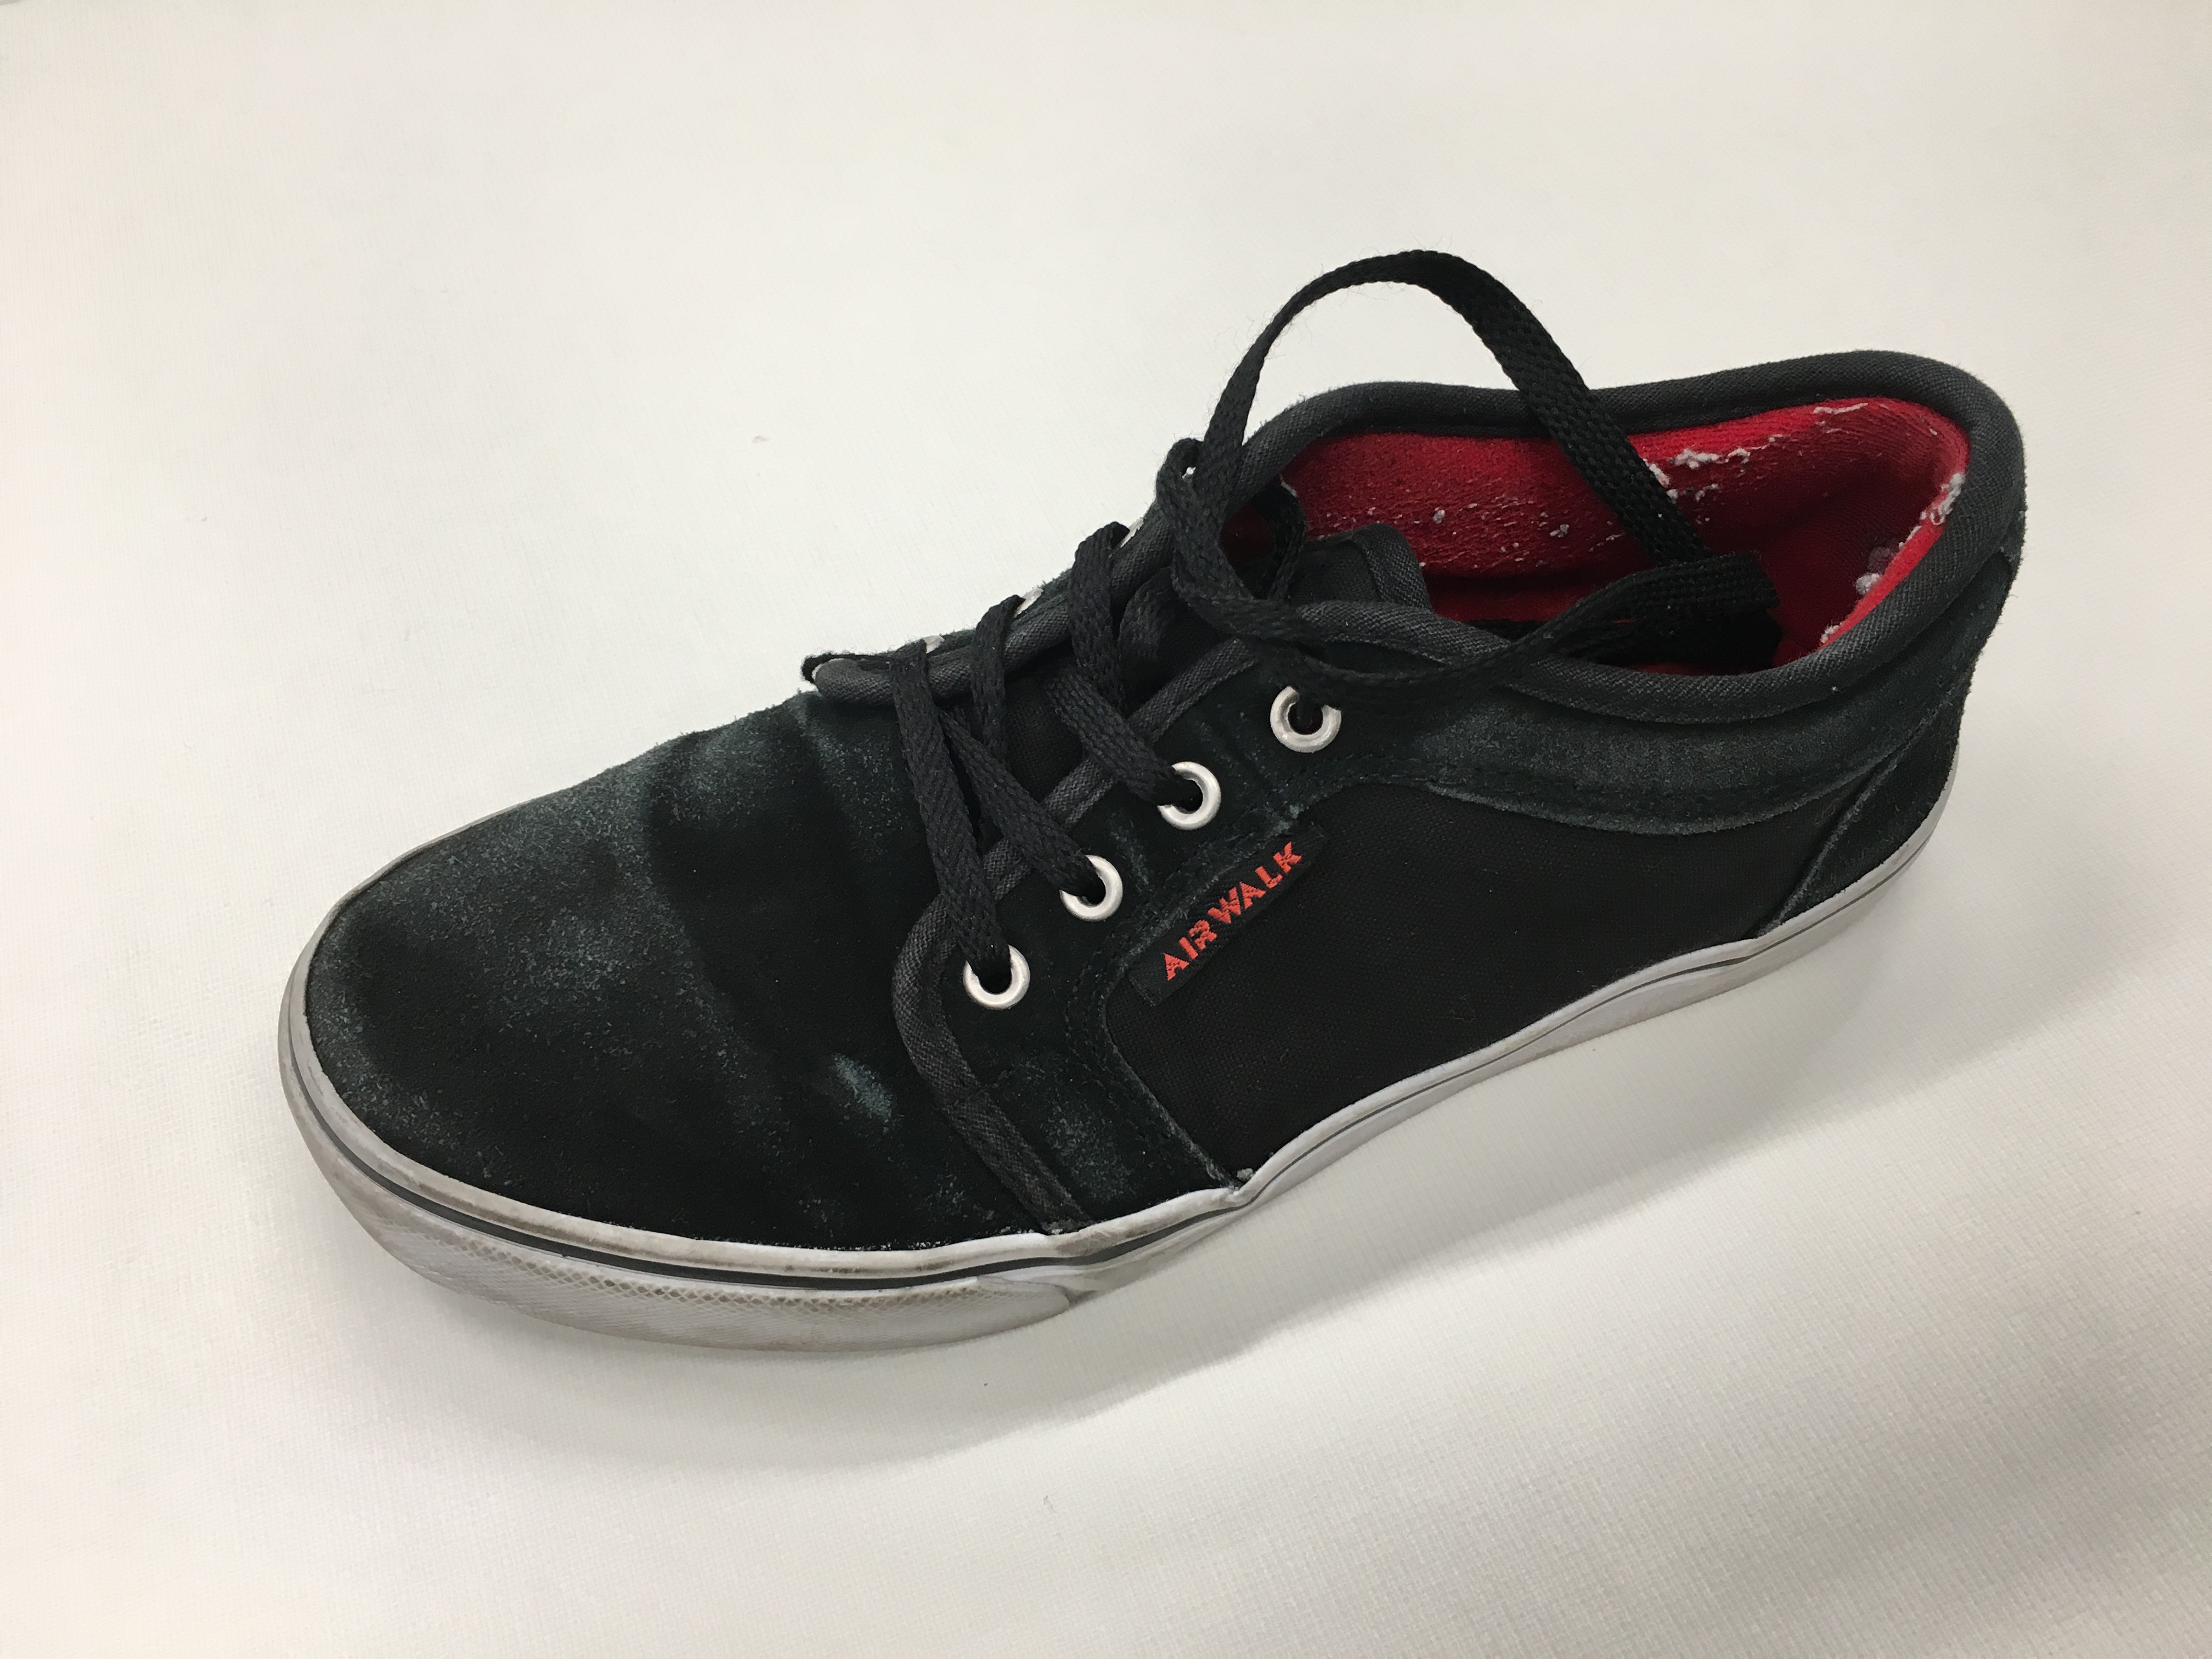

In [197]:
Image(filename=img_path, width=300)

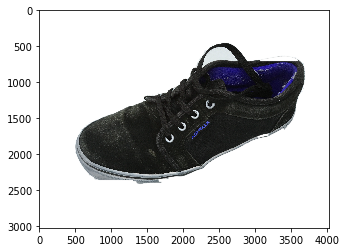

In [198]:
img_background= cv2.imread(img_background_path)
plt.imshow(img_background)

In [199]:
img_background_path = "./temp/resized_img.jpg"
temp_recog_path = "./temp/temp_recog_recognition.jpg"

'black'

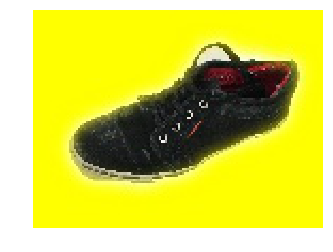

In [200]:
color_recognition(img_background_path, temp_recog_path, class_names[predict_path(img_background_path)])

In [201]:
category = predict_path(img_background_path)

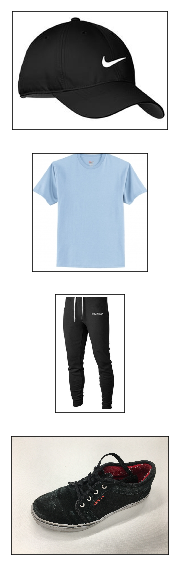

In [207]:
colorMapWithInput(color_recognition_noplot(img_background_path, temp_recog_path, class_names[category]), 
                  category, 
                  img_path)

## Demo 02 (All-in-one)

In [216]:
img_path = "../shoes-recognition/shoesimages/demos/jason01.jpg"

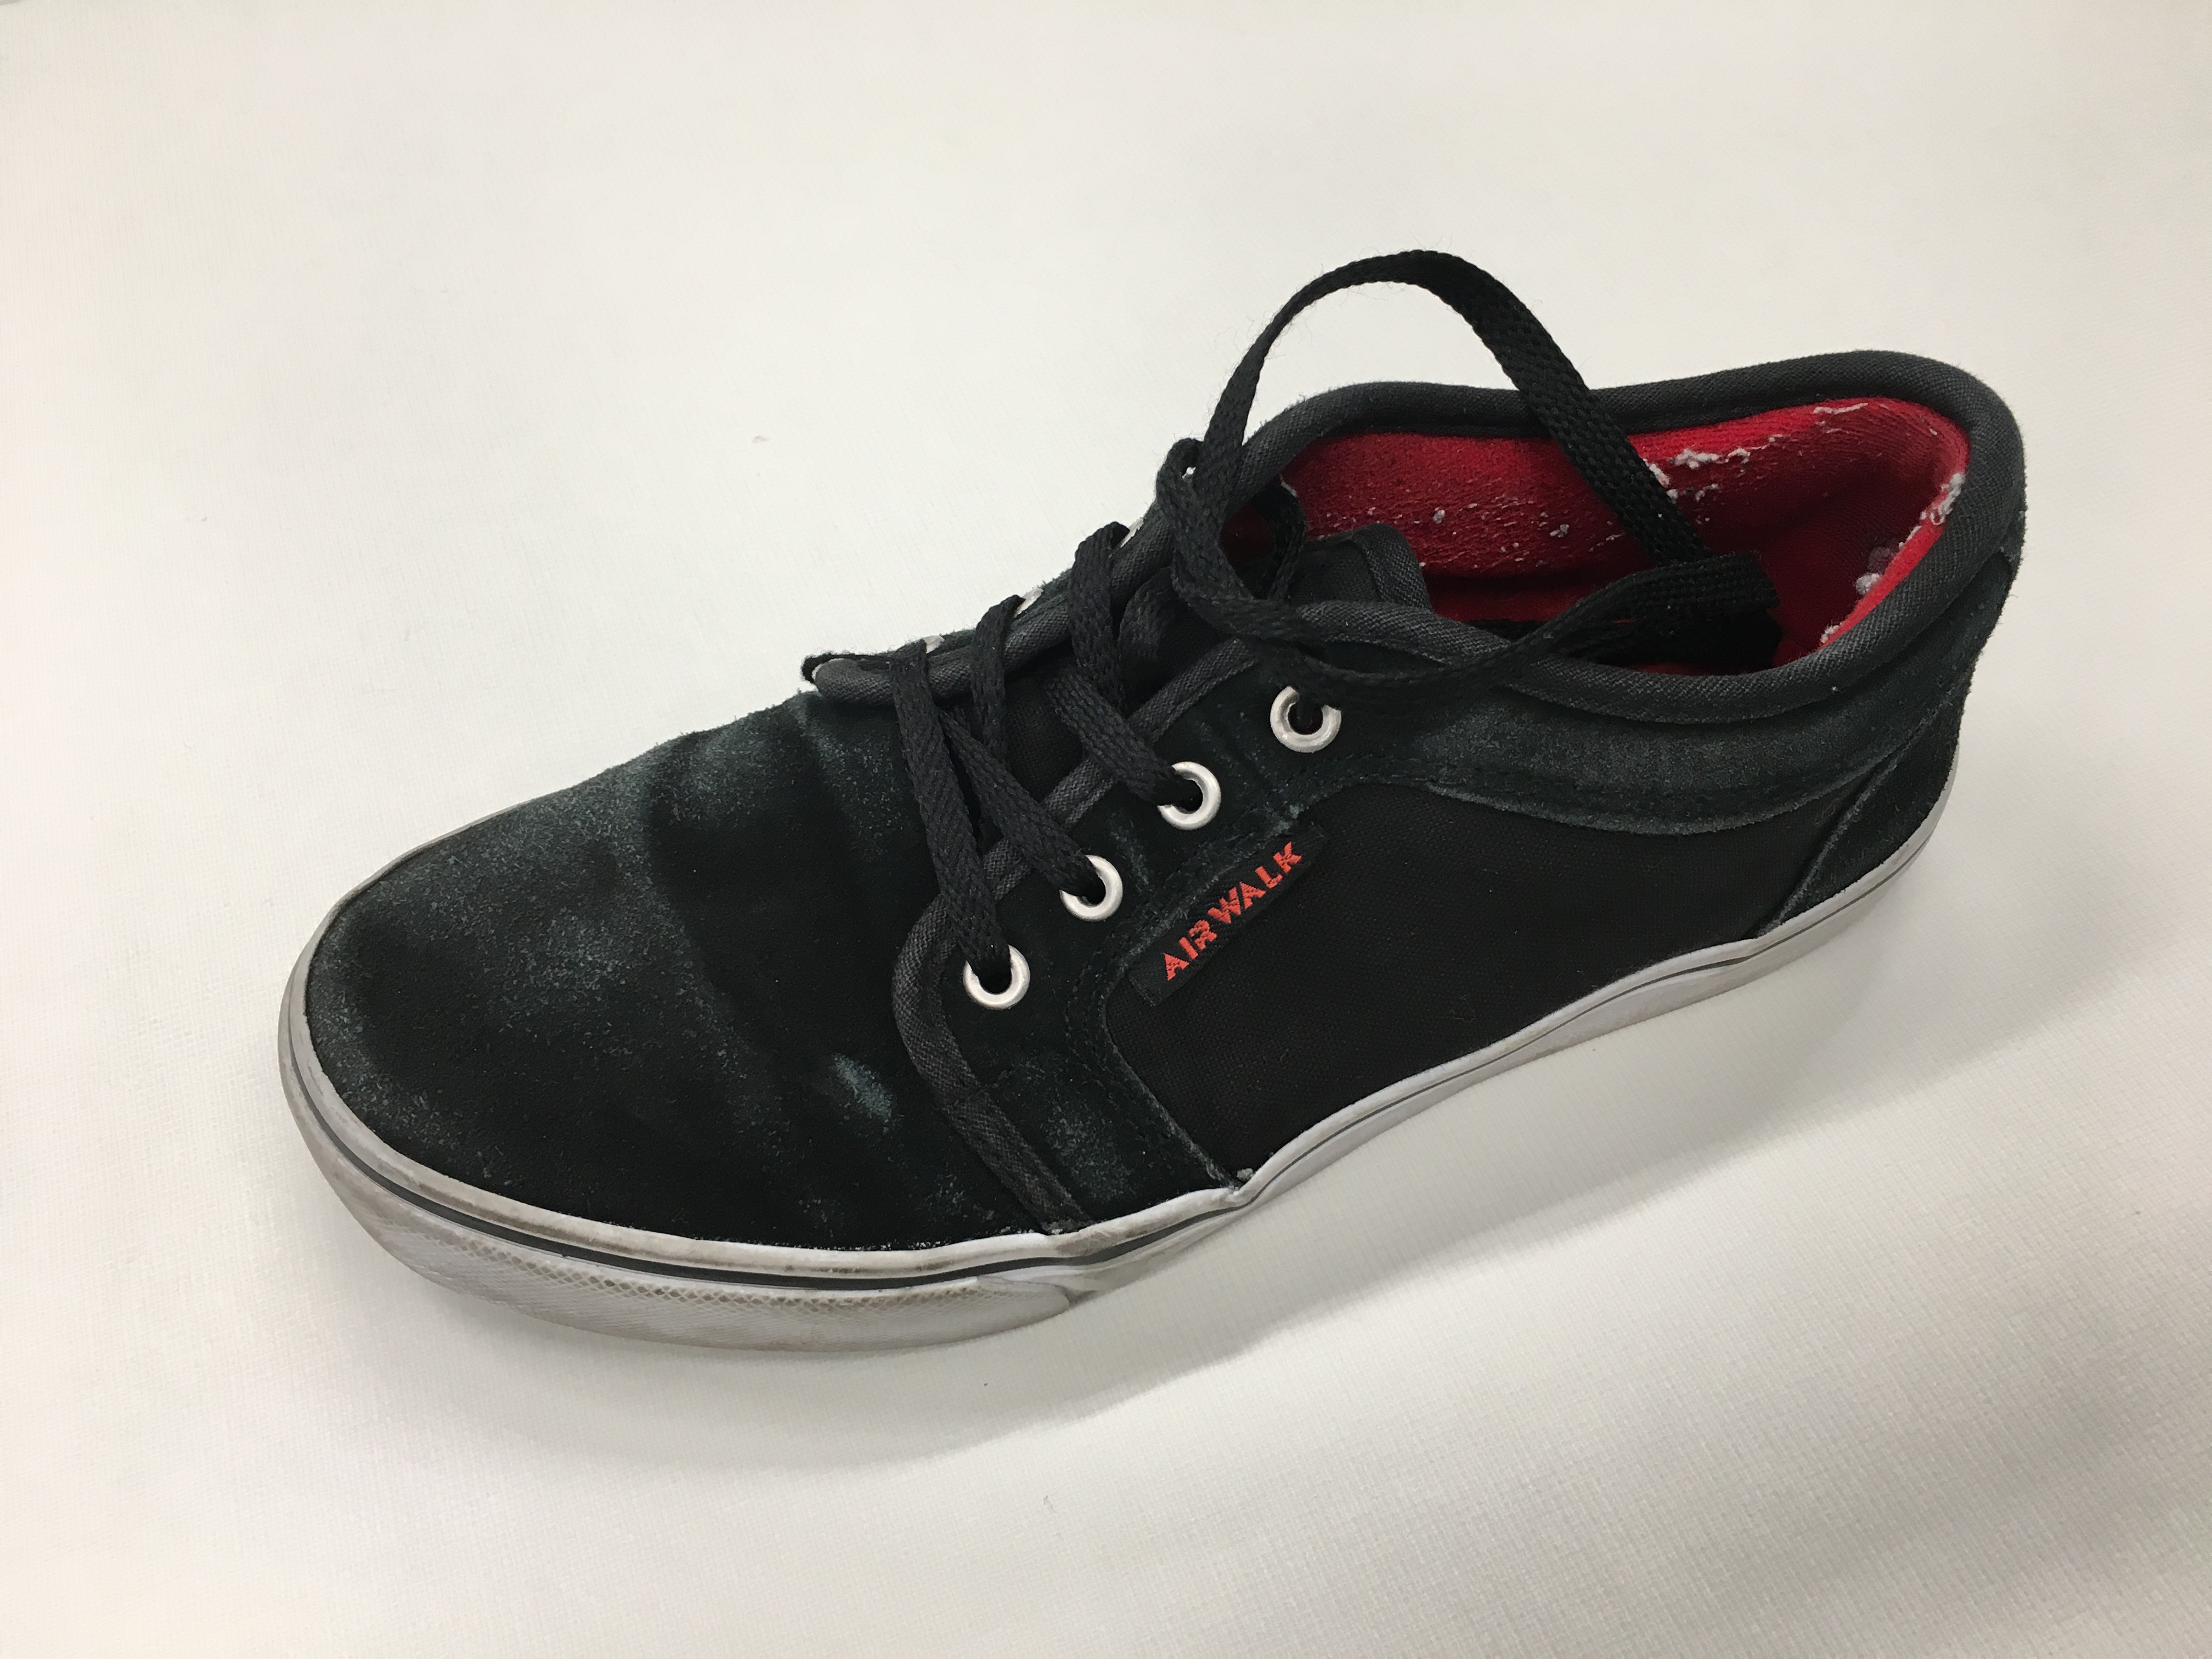

In [217]:
Image(filename=img_path, width=300)

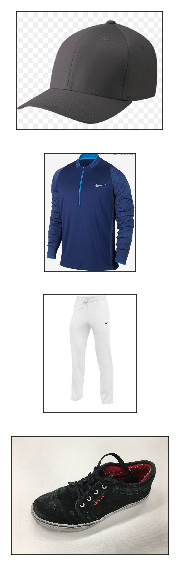

In [218]:
fashionBoard(img_path)